This notebook goes through how to create a **segmented line** and **convert** it into a **polygon**.

# IMPORTS

In [1]:
import matplotlib.pyplot as plt

from spomso.cores.helper_functions import generate_grid, smarter_reshape
from spomso.cores.post_processing import hard_binarization
from spomso.cores.geom_2d import SegmentedParametricCurve, SegmentedLine

# PARAMETERS

In [2]:
# size of the volume
co_size = 4, 6
# resolution of the volume
co_resolution = 400, 600

show = "FIELD" # BINARY, FIELD
show_midplane = True

# COORDINATE SYSTEM

Point cloud of coordinates is created with the **generate_grid** function, which takes the size of the coordinate system and the number of points in each direction (**co_resolution**).

In [3]:
coor, co_res_new = generate_grid(co_size, co_resolution)

If there is an even number of points along any direction the function will automatically convert it to an odd number, therefore the origin is always included in the point cloud. The point cloud is a numpy.ndarray with a shape of **(D, N)**, where **D** is the number of dimensions and **N** is the number of data points.

# CREATE SDFs

There are two ways how to evaluate a **segmented line**.
The parametric approach allows us to calculate the SDF for only a section of the **segmented line**.
The non-parametric approach calculates the SDF of the whole **segmented line**.

In [4]:
parametric_evaluate = True

The **closed segmented line** can also be converted into a **polygon**. Where the enclosed area will be on the inside of the **polygon**.

In [5]:
polygon = True

First the **vertices** (**points**) of the **segmented line** must be defined:

In [6]:
points = [[-1, -2, 0], [1, 2, 0], [-1, 2, 0],  [1, -2, 0]]

Create a **segmented line** from the **points**. The **line** is **closed** on itself by setting **closed=True**.

In [7]:
if parametric_evaluate:
    spc = SegmentedParametricCurve(points, (0, 4, 200), closed=True)
else:
    spc = SegmentedLine(points, closed=True)

The second parameter in the **SegmentedParametricCurve** denotes the range of points for which the **segmented line** will be evaluated. In this case from the position of the first (**0**) point to the position of the last (**4**) in **200** steps. The first two numbers can also be *floats*.

Since the **segmented line** is closed it can be converted into a **polygon** (works only if the line is closed):

In [8]:
if polygon:
    spc.polygon()

To get the **sign/interior** of an SDF:

In [9]:
spc_sign = spc.sign(direct=True)

The line can be recovered with:

In [10]:
spc.boundary()

<function spomso.cores.modifications.ModifyObject.boundary.<locals>.new_geo_object(co, *params)>

The interior can be recovered with a function:

In [11]:
spc.recover_volume(spc_sign)

<function spomso.cores.modifications.ModifyObject.recover_volume.<locals>.new_geo_object(co, *params)>

The interior can be redefined with a function:

In [12]:
# spc.define_volume(some_sign_function, some_sign_function_parameters)

In general a **line** or a **curve** can converted into a **surface** by applying **rounding** with some rounding radius, in this case **0.1**:

In [13]:
if not polygon:
    spc.rounding(0.1)

## EVALUATE

Evaluate the SDF of the **segmented line** to create a signed distance field 2D map. This is done by calling the **create** method and passing in the point cloud of coordinates:

In [14]:
segmented_line_pattern = spc.create(coor)

# BINARIZATION

Convert the distance field to a binary voxel map, where 1 corresponds to the interior and 0 to the exterior of the geometry.

In [15]:
if show_midplane:
    field = smarter_reshape(segmented_line_pattern, co_resolution)
    if show=="BINARY":
        pattern_2d = hard_binarization(field, 0)

# PLOT

Drawing results...
(401, 601)


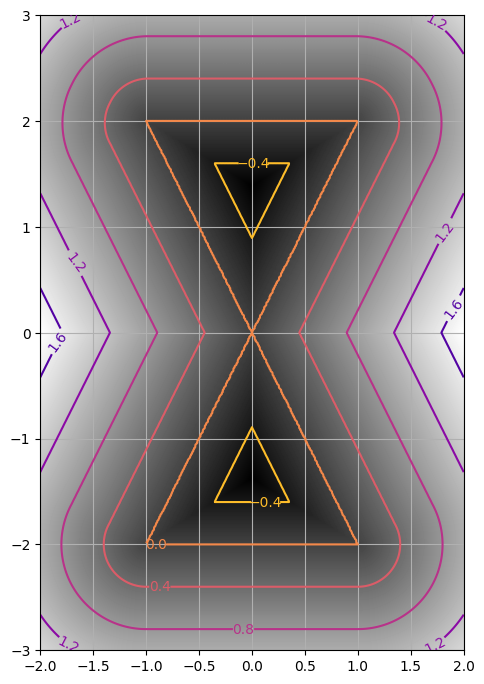

In [16]:
print("Drawing results...")
# Mid-plane cross-section plot
if show_midplane and show=="BINARY":
    fig, ax = plt.subplots(1,1, figsize=(8.25, 8.25))
    ax.imshow(pattern_2d[:, :].T,
              cmap="binary_r",
              extent=(-co_size[0]/2, co_size[0]/2,
                      -co_size[1]/2, co_size[1]/2),
              origin="lower"
              )
    ax.grid()

    fig.tight_layout()
    plt.show()

if show_midplane and show == "FIELD":
    fig, ax = plt.subplots(1, 1, figsize=(8.25, 8.25))
    print(field.shape)
    ax.imshow(field[:, :].T,
              cmap="binary_r",
              extent=(-co_size[0] / 2, co_size[0] / 2,
                      -co_size[1] / 2, co_size[1] / 2),
              origin="lower"
              )
    cs = ax.contour(coor[0].reshape(co_res_new[0], co_res_new[1]),
                    coor[1].reshape(co_res_new[0], co_res_new[1]),
                    field[:, :],
                    cmap="plasma_r")
    ax.clabel(cs, inline=True, fontsize=10)
    ax.grid()